# Predicting phage lifecycle
### Phagos hackathon 2025

### Bhupen Dabholkar and Parth Pandit

## Bacteriophage lifecycle 
![Alt text](phagelifecycle.png)


#### Using the power of LLMs and machine learning to predict if the lifecycle of a bacteriophage is lytic or lysogenic

### Datasets

Link provided from the hackathon - https://s3.eu-west-1.amazonaws.com/phagos-rd-hackathon25-datasets/deephage/deephage_lifestyle.tar.gz

The data has 4 folders with multi fasta files containing dna sequences of different bacteriophages. The folders are labelled as 'virulent' and 'temperate' which corresponds to 'lytic' and 'lysogenic' respectively.

### Installing the libraries

In [78]:
! pip install -q fair-esm
! pip install tqdm
! pip install biopython
! pip install xgboost

### Extracting the amino acid sequences (proteins) from the phage genomes

In [12]:
#Using the library biopython to read the fasta files
from Bio import SeqIO

records = list(SeqIO.parse("data/Dataset-1_temperate.fasta", "fasta"))
N_PHAGES_LYSOGENIC_1 = len(records)

records = list(SeqIO.parse("data/Dataset-2_temperate.fasta", "fasta"))
N_PHAGES_LYSOGENIC_2 = len(records)

records = list(SeqIO.parse("data/Dataset-1_virulent.fasta", "fasta"))
N_PHAGES_LYSIC_1 = len(records)

records = list(SeqIO.parse("data/Dataset-2_virulent.fasta", "fasta"))
N_PHAGES_LYSIC_2 = len(records)

In [13]:
print('number of lysogenic phages in dataset 1 :', N_PHAGES_LYSOGENIC_1)
print('number of lysogenic phages in dataset 2 :', N_PHAGES_LYSOGENIC_2)
print('number of lysic phages in dataset 1 :',  N_PHAGES_LYSIC_1)
print('number of lysic phages in dataset 2 :',  N_PHAGES_LYSIC_2)

number of lysogenic phages in dataset 1 : 148
number of lysogenic phages in dataset 2 : 429
number of lysic phages in dataset 1 : 77
number of lysic phages in dataset 2 : 1211


##### To extract the proteins from the phage genomes we will use a library called Prodigal - https://github.com/hyattpd/Prodigal

In [ ]:
# To install prodigal - 
!conda install -c bioconda -y prodigal

The following commands take some time. In particular for 'Dataset-2_virulent.fasta'

In [82]:
# Extract the proteins - 

! prodigal -i data/Dataset-2_virulent.fasta -a proteins/Dataset-2_virulent_proteins.faa -p meta > /dev/null 2>&1

In [3]:
! prodigal -i data/Dataset-1_virulent.fasta -a proteins/Dataset-1_virulent_proteins.faa -p meta > /dev/null 2>&1

In [4]:
! prodigal -i data/Dataset-2_temperate.fasta -a proteins/Dataset-2_temperate_proteins.faa -p meta > /dev/null 2>&1

In [5]:
! prodigal -i data/Dataset-1_temperate.fasta -a proteins/Dataset-1_temperate_proteins.faa -p meta > /dev/null 2>&1

##### The generated .faa files contain '*' at the end of each amino acid sequence. We will remove the character from these files as the model we sill use next does not recognize it.

In [6]:
! sed -i 's/[*]//g' proteins/Dataset-1_virulent_proteins.faa
! sed -i 's/[*]//g' proteins/Dataset-2_virulent_proteins.faa
! sed -i 's/[*]//g' proteins/Dataset-1_temperate_proteins.faa
! sed -i 's/[*]//g' proteins/Dataset-2_temperate_proteins.faa

### Embeddings

#### To extract embeddings from the amino acid sequences we will use a pre-trained ESM model (https://github.com/facebookresearch/esm?tab=readme-ov-file#available). In particular ESM 2 (esm2_t6_8M_UR50D) which is relatively light weight with 8M parameters and an embedding dimension 320.

In [7]:
#Importing the required libraries
import pathlib
import torch
from tqdm.notebook import tqdm

from esm import FastaBatchedDataset, pretrained
import os

In [8]:
# This function is taken from - https://www.kaggle.com/code/viktorfairuschin/extracting-esm-2-embeddings-from-fasta-files/notebook
#
# It will store all the protein embeddings for each phage on disk. 

def extract_embeddings(model_name, fasta_file, n_phages, output_path, tokens_per_batch=4096, seq_length=1022,repr_layers=[6]):
    '''
    model_name : the name of the model. We use 'esm2_t6_8M_UR50D'
    fasta_file : the path to .faa files
    n_phages : total number of phages for each class
    output_path : path to the directory for storing the embeddings
    tokens_per_batch : number of tokens to process per batch
    seq_length : the maximum amino acid sequence length the model can take
    '''
    model, alphabet = pretrained.load_model_and_alphabet(model_name)
    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()
        
    dataset = FastaBatchedDataset.from_file(fasta_file)
    batches = dataset.get_batch_indices(tokens_per_batch, extra_toks_per_seq=1)

    data_loader = torch.utils.data.DataLoader(
        dataset, 
        collate_fn=alphabet.get_batch_converter(seq_length), 
        batch_sampler=batches
    )

    embeds_per_protein = {str(i) : [] for i in range(1, n_phages+1)}
    
    with torch.no_grad():
        for batch_idx, (labels, strs, toks) in enumerate(tqdm(data_loader, desc="Encoding", total=len(data_loader))):

            #print(f'Processing batch {batch_idx + 1} of {len(batches)}')

            if torch.cuda.is_available():
                toks = toks.to(device="cuda", non_blocking=True)

            out = model(toks, repr_layers=repr_layers, return_contacts=False)

            logits = out["logits"].to(device="cpu")
            representations = {layer: t.to(device="cpu") for layer, t in out["representations"].items()}
            
            for i, label in enumerate(labels):
                entry_id = label.split('ID=')[1].split(';')[0].split('_')[0]

                #Truncate long sequences
                truncate_len = min(seq_length, len(strs[i]))

                result = {"entry_id": entry_id}
                result["mean_representations"] = [
                        t[i, 1 : truncate_len + 1].mean(0).clone()
                        for layer, t in representations.items()]

                embeds_per_protein[entry_id].append(result['mean_representations'][0])

    os.makedirs(output_path, exist_ok=True)
    for phage_id in embeds_per_protein:
        torch.save(embeds_per_protein[phage_id], output_path + phage_id + '.pt')


In [14]:
model_name = 'esm2_t6_8M_UR50D'
fasta_file = pathlib.Path('proteins/Dataset-2_virulent_proteins.faa')

extract_embeddings(model_name, fasta_file, N_PHAGES_LYSIC_2, 'Embeddings/Dataset-2_virulent/')

Encoding:   0%|          | 0/7838 [00:00<?, ?it/s]

In [ ]:
fasta_file = pathlib.Path('proteins/Dataset-1_virulent_proteins.faa')

extract_embeddings(model_name, fasta_file, N_PHAGES_LYSIC_1, 'Embeddings/Dataset-1_virulent/')

Encoding:   0%|          | 0/463 [00:00<?, ?it/s]

In [16]:
fasta_file = pathlib.Path('proteins/Dataset-1_temperate_proteins.faa')

extract_embeddings(model_name, fasta_file, N_PHAGES_LYSOGENIC_1, 'Embeddings/Dataset-1_temperate/')

Encoding:   0%|          | 0/519 [00:00<?, ?it/s]

In [17]:
fasta_file = pathlib.Path('proteins/Dataset-2_temperate_proteins.faa')

extract_embeddings(model_name, fasta_file, N_PHAGES_LYSOGENIC_2, 'Embeddings/Dataset-2_temperate/')

Encoding:   0%|          | 0/1685 [00:00<?, ?it/s]

### Creating a data frame

##### Now that we have stored the embeddings on disk we could create a nice data frame to be used for the classification task

In [20]:
import pandas as pd

In [18]:
def create_df(label, dir_name):
    '''
    Function return a pandas data frame with two columns - 'Embeddings' and 'labels'
    '''
    
    path_to_dir = 'Embeddings/' + dir_name
    embeddings = []
    
    for fname in os.listdir(path_to_dir):

        path_to_file = path_to_dir + '/' + fname
        all_tensors = torch.load(path_to_file)

        # Since each phage has multiple proteins, to extract a single embedding per phage we
        # take the mean embedding of all the proteins.
        embeddings.append(torch.stack(all_tensors).mean(0).squeeze().numpy())

    return pd.DataFrame({'Embeddings' : embeddings, 'labels' : label})
        
    

In [25]:
df = pd.concat([create_df('lysic', 'Dataset-1_virulent'), create_df('lysic', 'Dataset-2_virulent'), create_df('lysogenic', 'Dataset-1_temperate'), create_df('lysogenic', 'Dataset-2_temperate')])
df = df.reset_index(drop=True)
df

,Embeddings,labels
0,"[-0.05853875, -0.03559405, 0.1571865, 0.197030...",lysic
1,"[-0.05206919, -0.062334787, 0.14913075, 0.1167...",lysic
2,"[-0.073517986, -0.026214214, 0.13497724, 0.103...",lysic
3,"[-0.06637349, -0.041989934, 0.15498395, 0.1442...",lysic
4,"[-0.047471665, -0.05996416, 0.15609127, 0.1459...",lysic
...,...,...
1860,"[-0.07939046, -0.07276801, 0.159734, 0.1705044...",lysogenic
1861,"[-0.046599425, -0.07957475, 0.13376476, 0.0367...",lysogenic
1862,"[-0.043071344, -0.047865696, 0.15949711, 0.108...",lysogenic
1863,"[-0.065825194, -0.08668357, 0.15463431, 0.2044...",lysogenic


## Data imbalance !

In [26]:
print('fraction of Lysic phages :' , (df['labels'] == 'lysic').sum() / df.shape[0])
print('fraction of Lysogenic phages :' , (df['labels'] == 'lysogenic').sum() / df.shape[0])

fraction of Lysic phages : 0.6906166219839142
fraction of Lysogenic phages : 0.3093833780160858


## Classification with XGBoost

In [39]:
! pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 75.3 MB/s eta 0:00:00


In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [28]:
X = np.vstack(df['Embeddings'].values)  # shape: (n_samples, embedding_dim)
y = df['labels'].values

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# xgboost can take into account data imbalance
scale = (y_encoded == 0).sum() / (y_encoded == 1).sum()

In [30]:
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale
)

y_pred_encoded = cross_val_predict(model, X, y_encoded, cv=5)

In [31]:
y_true_str = le.inverse_transform(y_encoded)
y_pred_str = le.inverse_transform(y_pred_encoded)

In [32]:
# Confusion matrix
cm = confusion_matrix(y_true_str, y_pred_str, labels = le.classes_)
print("Confusion Matrix:\n", cm)

# Detailed classification report (precision, recall, f1)
print("\nClassification Report:\n", classification_report(y_true_str, y_pred_str, target_names=le.classes_))

Confusion Matrix:
 [[1204   84]
 [  89  488]]

Classification Report:
               precision    recall  f1-score   support

       lysic       0.93      0.93      0.93      1288
   lysogenic       0.85      0.85      0.85       577

    accuracy                           0.91      1865
   macro avg       0.89      0.89      0.89      1865
weighted avg       0.91      0.91      0.91      1865



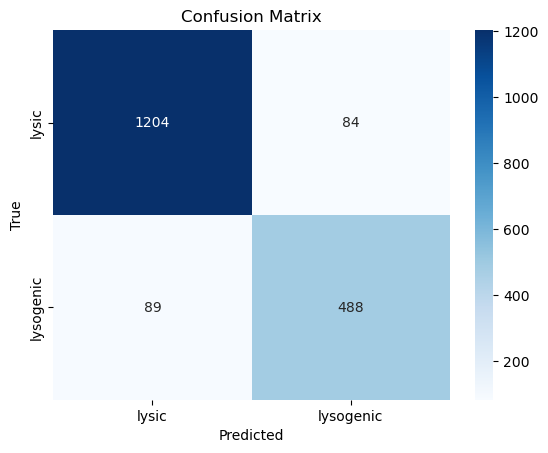

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_str, y_pred_str, labels=le.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Thank you